In [1]:
#Import Library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import KNNWithMeans, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB
Minimum rating: 1.0
Maximum rating: 5.0


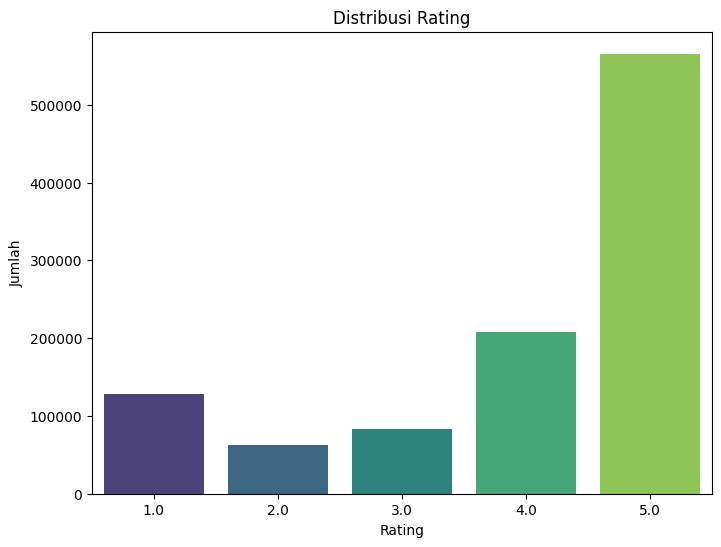

Total ratings: 1048576
Total unique users: 786330
Total unique products: 61894


In [7]:
# Membaca dataset
electronics_data = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId', 'Rating', 'timestamp'])

# Tampilkan beberapa baris pertama data
electronics_data.head()

# Cek dimensi data
electronics_data.shape

# Ambil subset data untuk efisiensi (opsional)
electronics_data = electronics_data.iloc[:1048576, :]

# Cek tipe data
electronics_data.dtypes

# Info ringkas dataset
electronics_data.info()

# Statistik deskriptif untuk kolom Rating
electronics_data['Rating'].describe()

# Cek nilai minimum dan maksimum pada kolom Rating
print(f"Minimum rating: {electronics_data['Rating'].min()}")
print(f"Maximum rating: {electronics_data['Rating'].max()}")

# Cek nilai yang hilang
electronics_data.isnull().sum()

# Visualisasi distribusi rating
plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=electronics_data, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

# Total jumlah user dan produk unik
print(f"Total ratings: {electronics_data.shape[0]}")
print(f"Total unique users: {electronics_data['userId'].nunique()}")
print(f"Total unique products: {electronics_data['productId'].nunique()}")

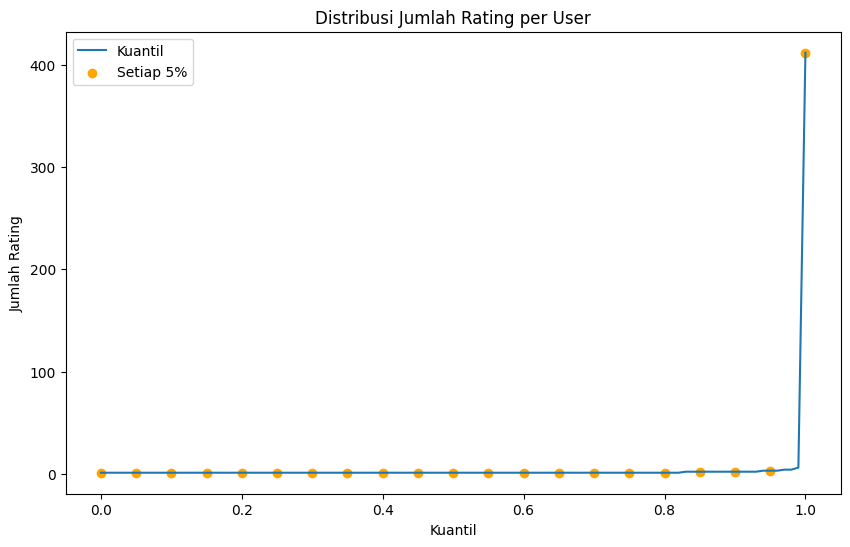

In [8]:
# Hapus kolom timestamp karena tidak relevan
electronics_data.drop(columns=['timestamp'], inplace=True)

# Analisis jumlah produk yang dirating oleh tiap user
ratings_per_user = electronics_data.groupby('userId')['Rating'].count().sort_values(ascending=False)

# Kuantil jumlah rating per user
quantiles = ratings_per_user.quantile(np.arange(0, 1.01, 0.01))
plt.figure(figsize=(10, 6))
plt.plot(quantiles, label='Kuantil')
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='Setiap 5%')
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Kuantil')
plt.ylabel('Jumlah Rating')
plt.legend()
plt.show()

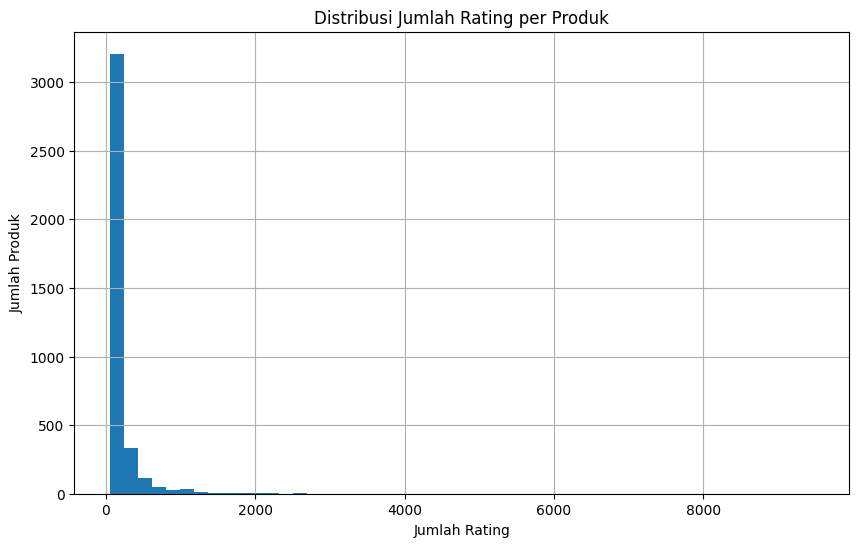

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [9]:
# Buat dataset baru hanya dengan produk yang memiliki >=50 rating
popular_products = electronics_data.groupby('productId').filter(lambda x: len(x) >= 50)

# Visualisasi jumlah rating per produk
ratings_per_product = popular_products.groupby('productId')['Rating'].count()
plt.figure(figsize=(10, 6))
ratings_per_product.hist(bins=50)
plt.title('Distribusi Jumlah Rating per Produk')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Produk')
plt.show()

# Rata-rata rating per produk
average_ratings = popular_products.groupby('productId')['Rating'].mean()
average_ratings.sort_values(ascending=False).head()

In [10]:
# Collaborative Filtering (Item-Based)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(popular_products[['userId', 'productId', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

# Model item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

# Evaluasi model
predictions = algo.test(testset)
print("Item-Based Collaborative Filtering - RMSE:")
accuracy.rmse(predictions, verbose=True)

# Model-based Collaborative Filtering
subset_data = popular_products.head(10000)  # Subset data untuk efisiensi
ratings_matrix = subset_data.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)

# Transpos matriks
ratings_matrix_T = ratings_matrix.T

# Decomposisi matriks menggunakan SVD
svd = TruncatedSVD(n_components=10, random_state=42)
decomposed_matrix = svd.fit_transform(ratings_matrix_T)

# Matriks korelasi
correlation_matrix = np.corrcoef(decomposed_matrix)

# Rekomendasi produk
product_id = "B00000K135"  # Contoh ID produk
product_idx = list(ratings_matrix_T.index).index(product_id)
correlation_product = correlation_matrix[product_idx]
recommended_products = list(ratings_matrix_T.index[correlation_product > 0.65])
if product_id in recommended_products:
    recommended_products.remove(product_id)

print("Rekomendasi Produk:")
print(recommended_products[:25])


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Item-Based Collaborative Filtering - RMSE:
RMSE: 1.3436
Rekomendasi Produk:
['1400599997', '6301977173', '9983891212', '9984984354', '9985511476', 'B000001OM4', 'B000001ON6', 'B00000J0D8', 'B00000J1F3', 'B00000J1TX', 'B00000J3UJ', 'B00000JCTO', 'B00000JD34', 'B00000JHWX', 'B00000JPPI', 'B00000JYLO']
